In [53]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import time

from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

warnings.filterwarnings('ignore')

DATA_DIR = Path('Data')
MODELS_DIR = Path('models/saved_models')
RESULTS_DIR = Path('results')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [54]:
X_metrics_df = pd.read_csv(DATA_DIR / 'X' / 'X_metrics_processed.csv')
Y_df = pd.read_csv(DATA_DIR / 'Y' / 'Y.csv')

data = X_metrics_df.merge(
    Y_df[['filename', 'VehId', 'DayNum', 'Trip', 
          'Y_consumption_combustion_L_per_100km', 
          'Y_consumption_electric_kWh_per_km']], 
    on=['filename', 'VehId', 'DayNum', 'Trip'], 
    how='inner'
)

exclude_cols = ['filename', 'DayNum', 'Trip', 'Timestamp', 'Timestamp(ms)', 
                'Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km']

feature_cols = [col for col in data.columns 
               if col not in exclude_cols 
               and col != 'VehId'
               and col != 'filename'
               and data[col].dtype in [np.float64, np.int64]]

X = data[feature_cols].fillna(data[feature_cols].mean())

target_cols = ['Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km']
target_names = ['Combustión (L/100km)', 'Eléctrico (kWh/km)']

y_combustion = data['Y_consumption_combustion_L_per_100km'].fillna(0).values
y_electric = data['Y_consumption_electric_kWh_per_km'].fillna(0).values

print(f"Total samples: {len(X)}")
print(f"Features: {len(feature_cols)}")

Total samples: 32512
Features: 98


In [55]:
# Split: Dev (80%) y Test (20%) - El test set se guarda intacto para evaluación final
indices = np.arange(len(X))

idx_dev, idx_test = train_test_split(indices, test_size=0.2, random_state=69)

X_dev = X.iloc[idx_dev]
X_test = X.iloc[idx_test]

# Splits para ambos targets
y_combustion_dev = y_combustion[idx_dev]
y_combustion_test = y_combustion[idx_test]

y_electric_dev = y_electric[idx_dev]
y_electric_test = y_electric[idx_test]

print(f"Dev set: {len(X_dev)} samples ({len(X_dev)/len(X)*100:.1f}%)")
print(f"Test set (HOLDOUT): {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

Dev set: 26009 samples (80.0%)
Test set (HOLDOUT): 6503 samples (20.0%)


In [56]:
# Escalar datos del Dev set para hyperparameter search
scaler_dev = StandardScaler()
X_dev_scaled = scaler_dev.fit_transform(X_dev)
X_dev_scaled = pd.DataFrame(X_dev_scaled, columns=feature_cols, index=X_dev.index)

# Sanitizar nombres de columnas (remover brackets para compatibilidad con XGBoost)
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') 
                          for col in feature_cols]
X_dev_scaled.columns = sanitized_feature_cols

print(f"Dev set escalado: {X_dev_scaled.shape}")
print(f"Media: {X_dev_scaled.mean().mean():.6f}")
print(f"Std: {X_dev_scaled.std().mean():.6f}")

Dev set escalado: (26009, 98)
Media: -0.000000
Std: 1.000019


In [57]:
# Definir espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 a 0.30
    'subsample': uniform(0.6, 0.4),         # 0.6 a 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 a 1.0
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2),
}

# Modelo base
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=69,
    n_jobs=-1,
    verbosity=0
)

print("Espacio de búsqueda definido:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Espacio de búsqueda definido:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002462C2ABA90>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002462C2AB290>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002462C2A9010>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002462C2A9690>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002467F70DD10>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024615EFFA50>
  gamma: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002461093F810>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002461093EF50>
  reg_lambda: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002461093EA10>


In [58]:
# Función para ejecutar hyperparameter search
def run_hyperparameter_search(X_scaled, y, target_name, n_iter=50):
    print(f"\n{'='*60}")
    print(f"HYPERPARAMETER SEARCH: {target_name}")
    print(f"{'='*60}")
    print(f"  - Iteraciones: {n_iter}")
    print(f"  - Cross-validation folds: 5")
    print(f"  - Scoring: neg_root_mean_squared_error")
    print()
    
    start_time = time.time()
    
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=69,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    random_search.fit(X_scaled, y)
    
    elapsed_time = time.time() - start_time
    print(f"\n✓ Búsqueda completada en {elapsed_time/60:.1f} minutos")
    print(f"\nMejores hiperparámetros encontrados:")
    for param, value in random_search.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    print(f"\nMejor RMSE (CV): {-random_search.best_score_:.6f}")
    
    return random_search

# Ejecutar búsqueda para COMBUSTIÓN
print("Iniciando búsqueda de hiperparámetros...")
random_search_combustion = run_hyperparameter_search(
    X_dev_scaled, y_combustion_dev, "Combustión (L/100km)", n_iter=50
)

Iniciando búsqueda de hiperparámetros...

HYPERPARAMETER SEARCH: Combustión (L/100km)
  - Iteraciones: 50
  - Cross-validation folds: 5
  - Scoring: neg_root_mean_squared_error

Fitting 5 folds for each of 50 candidates, totalling 250 fitsFitting 5 folds for each of 50 candidates, totalling 250 fits


✓ Búsqueda completada en 5.4 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.7185
  gamma: 0.4045
  learning_rate: 0.1116
  max_depth: 7
  min_child_weight: 2
  n_estimators: 378
  reg_alpha: 0.1431
  reg_lambda: 0.5626
  subsample: 0.8657

Mejor RMSE (CV): 3.337863

✓ Búsqueda completada en 5.4 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.7185
  gamma: 0.4045
  learning_rate: 0.1116
  max_depth: 7
  min_child_weight: 2
  n_estimators: 378
  reg_alpha: 0.1431
  reg_lambda: 0.5626
  subsample: 0.8657

Mejor RMSE (CV): 3.337863


In [59]:
# Ejecutar búsqueda para ELÉCTRICO
random_search_electric = run_hyperparameter_search(
    X_dev_scaled, y_electric_dev, "Eléctrico (kWh/km)", n_iter=50
)


HYPERPARAMETER SEARCH: Eléctrico (kWh/km)
  - Iteraciones: 50
  - Cross-validation folds: 5
  - Scoring: neg_root_mean_squared_error

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Búsqueda completada en 0.7 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 380
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333

Mejor RMSE (CV): 0.018080

✓ Búsqueda completada en 0.7 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 380
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333

Mejor RMSE (CV): 0.018080


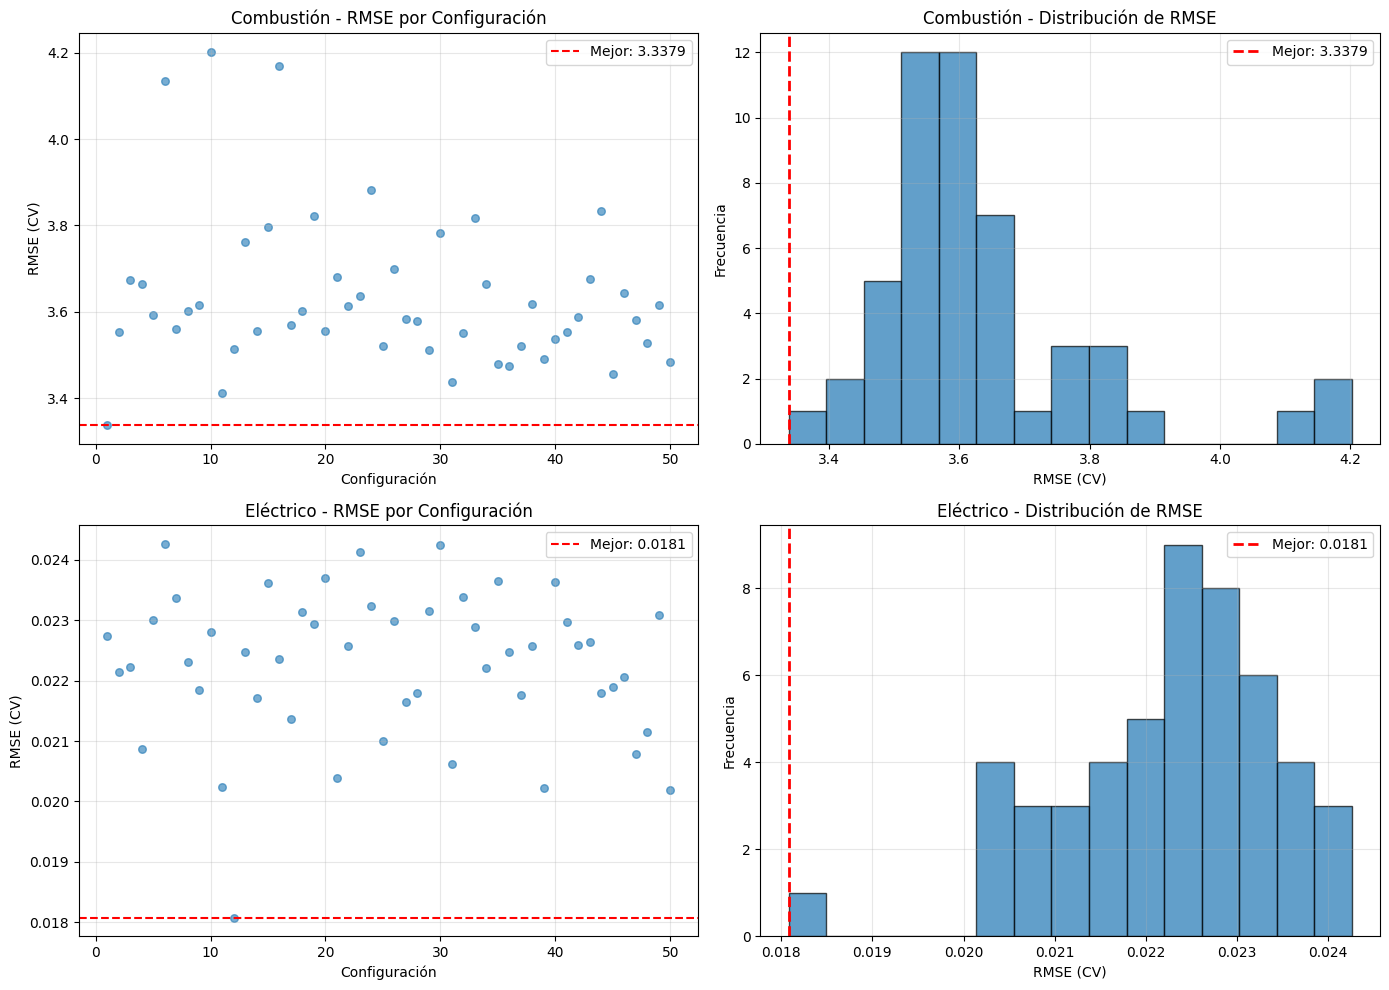

In [60]:
# Visualizar resultados de ambas búsquedas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (search, name) in enumerate([(random_search_combustion, 'Combustión'), 
                                        (random_search_electric, 'Eléctrico')]):
    cv_results = pd.DataFrame(search.cv_results_)
    scores = -cv_results['mean_test_score'].values
    
    # RMSE por configuración
    ax1 = axes[idx, 0]
    ax1.scatter(range(1, len(scores)+1), scores, alpha=0.6, s=30)
    ax1.axhline(y=-search.best_score_, color='r', linestyle='--', 
                label=f'Mejor: {-search.best_score_:.4f}')
    ax1.set_xlabel('Configuración')
    ax1.set_ylabel('RMSE (CV)')
    ax1.set_title(f'{name} - RMSE por Configuración')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Distribución de scores
    ax2 = axes[idx, 1]
    ax2.hist(scores, bins=15, edgecolor='black', alpha=0.7)
    ax2.axvline(x=-search.best_score_, color='r', linestyle='--', linewidth=2, 
                label=f'Mejor: {-search.best_score_:.4f}')
    ax2.set_xlabel('RMSE (CV)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title(f'{name} - Distribución de RMSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [61]:
# Función para crear y entrenar modelo final
def train_final_model(X_dev_scaled, y_dev, best_params, target_name):
    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO FINAL: {target_name}")
    print(f"{'='*60}")
    
    # Configurar hiperparámetros finales
    final_params = best_params.copy()
    final_params['n_estimators'] = 1000
    final_params['early_stopping_rounds'] = 50
    
    print("Configuración del modelo final:")
    for param, value in final_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    
    # Crear modelo
    model = xgb.XGBRegressor(
        **final_params,
        objective='reg:squarederror',
        random_state=69,
        n_jobs=-1,
        verbosity=1
    )
    
    # Split para early stopping (90% train, 10% val)
    X_train, X_val, y_train, y_val = train_test_split(
        X_dev_scaled, y_dev, test_size=0.1, random_state=69
    )
    
    print(f"\nTrain: {len(X_train)} samples, Validation: {len(X_val)} samples")
    print("Entrenando...")
    
    start_time = time.time()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
    elapsed_time = time.time() - start_time
    
    print(f"\n✓ Completado en {elapsed_time:.1f} segundos")
    print(f"  Iteraciones usadas: {model.best_iteration}")
    print(f"  Mejor RMSE (validation): {model.best_score:.6f}")
    
    return model

# Entrenar modelo de COMBUSTIÓN
model_combustion = train_final_model(
    X_dev_scaled, y_combustion_dev, 
    random_search_combustion.best_params_, 
    "Combustión (L/100km)"
)


ENTRENAMIENTO FINAL: Combustión (L/100km)
Configuración del modelo final:
  colsample_bytree: 0.7185
  gamma: 0.4045
  learning_rate: 0.1116
  max_depth: 7
  min_child_weight: 2
  n_estimators: 1000
  reg_alpha: 0.1431
  reg_lambda: 0.5626
  subsample: 0.8657
  early_stopping_rounds: 50

Train: 23408 samples, Validation: 2601 samples
Entrenando...
[0]	validation_0-rmse:4.79778
[50]	validation_0-rmse:2.86840
[50]	validation_0-rmse:2.86840
[100]	validation_0-rmse:2.65429
[100]	validation_0-rmse:2.65429
[150]	validation_0-rmse:2.57369
[150]	validation_0-rmse:2.57369
[200]	validation_0-rmse:2.53584
[200]	validation_0-rmse:2.53584
[250]	validation_0-rmse:2.50593
[250]	validation_0-rmse:2.50593
[300]	validation_0-rmse:2.49332
[300]	validation_0-rmse:2.49332
[350]	validation_0-rmse:2.47840
[350]	validation_0-rmse:2.47840
[400]	validation_0-rmse:2.47296
[400]	validation_0-rmse:2.47296
[450]	validation_0-rmse:2.46555
[450]	validation_0-rmse:2.46555
[500]	validation_0-rmse:2.46089
[500]	validat

In [62]:
# Entrenar modelo de ELÉCTRICO
model_electric = train_final_model(
    X_dev_scaled, y_electric_dev, 
    random_search_electric.best_params_, 
    "Eléctrico (kWh/km)"
)


ENTRENAMIENTO FINAL: Eléctrico (kWh/km)
Configuración del modelo final:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 1000
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333
  early_stopping_rounds: 50

Train: 23408 samples, Validation: 2601 samples
Entrenando...
[0]	validation_0-rmse:0.05050
[50]	validation_0-rmse:0.01740
[50]	validation_0-rmse:0.01740
[100]	validation_0-rmse:0.01705
[100]	validation_0-rmse:0.01705
[150]	validation_0-rmse:0.01699
[150]	validation_0-rmse:0.01699
[186]	validation_0-rmse:0.01704

✓ Completado en 0.5 segundos
  Iteraciones usadas: 136
  Mejor RMSE (validation): 0.016990
[186]	validation_0-rmse:0.01704

✓ Completado en 0.5 segundos
  Iteraciones usadas: 136
  Mejor RMSE (validation): 0.016990


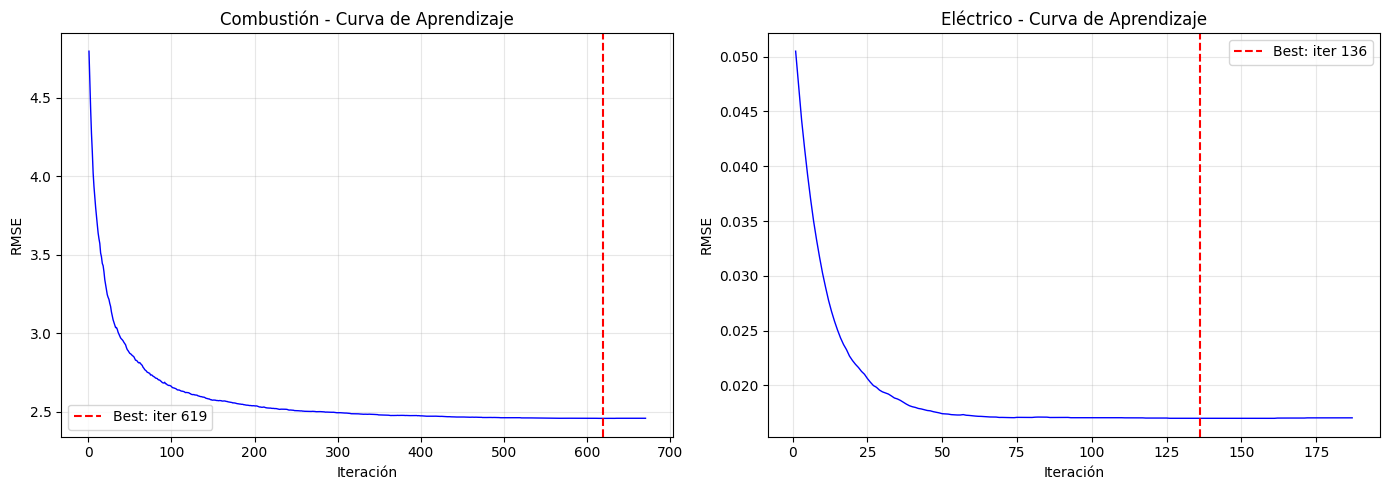

In [63]:
# Curvas de aprendizaje para ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (model, name) in enumerate([(model_combustion, 'Combustión'), 
                                      (model_electric, 'Eléctrico')]):
    results = model.evals_result()
    if 'validation_0' in results:
        val_rmse = results['validation_0']['rmse']
        
        ax = axes[idx]
        ax.plot(range(1, len(val_rmse)+1), val_rmse, 'b-', linewidth=1)
        ax.axvline(x=model.best_iteration, color='r', linestyle='--', 
                   label=f'Best: iter {model.best_iteration}')
        ax.set_xlabel('Iteración')
        ax.set_ylabel('RMSE')
        ax.set_title(f'{name} - Curva de Aprendizaje')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [64]:
# Preparar Test set
X_test_scaled = scaler_dev.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
X_test_scaled.columns = sanitized_feature_cols

print(f"Test set: {len(X_test_scaled)} samples")
print(f"\n{'='*70}")
print("                    EVALUACIÓN FINAL EN TEST SET")
print(f"{'='*70}\n")

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # MAPE solo para valores no cero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / np.abs(y_true[mask]))) * 100
    else:
        mape = np.nan
    
    return {'name': name, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

# Predicciones para COMBUSTIÓN
y_pred_combustion = model_combustion.predict(X_test_scaled)
metrics_combustion = calculate_metrics(y_combustion_test, y_pred_combustion, 'Combustión (L/100km)')

# Predicciones para ELÉCTRICO
y_pred_electric = model_electric.predict(X_test_scaled)
metrics_electric = calculate_metrics(y_electric_test, y_pred_electric, 'Eléctrico (kWh/km)')

# Mostrar resultados
print("MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)")
print(f"  MSE:  {metrics_combustion['mse']:.6f}")
print(f"  RMSE: {metrics_combustion['rmse']:.6f}")
print(f"  MAE:  {metrics_combustion['mae']:.6f}")
print(f"  R²:   {metrics_combustion['r2']:.6f}")
print(f"  MAPE: {metrics_combustion['mape']:.2f}%")

print(f"\nMODELO 2: CONSUMO ELÉCTRICO (kWh/km)")
print(f"  MSE:  {metrics_electric['mse']:.6f}")
print(f"  RMSE: {metrics_electric['rmse']:.6f}")
print(f"  MAE:  {metrics_electric['mae']:.6f}")
print(f"  R²:   {metrics_electric['r2']:.6f}")
print(f"  MAPE: {metrics_electric['mape']:.2f}%" if not np.isnan(metrics_electric['mape']) else "  MAPE: N/A")

# Comparación con CV scores
cv_rmse_combustion = -random_search_combustion.best_score_
cv_rmse_electric = -random_search_electric.best_score_

print(f"\n{'='*70}")
print("COMPARACIÓN CV vs TEST:")
print(f"  Combustión - CV RMSE: {cv_rmse_combustion:.4f}, Test RMSE: {metrics_combustion['rmse']:.4f}")
print(f"  Eléctrico  - CV RMSE: {cv_rmse_electric:.4f}, Test RMSE: {metrics_electric['rmse']:.4f}")
print(f"{'='*70}")

Test set: 6503 samples

                    EVALUACIÓN FINAL EN TEST SET

MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)
  MSE:  6.591672
  RMSE: 2.567425
  MAE:  1.326546
  R²:   0.750425
  MAPE: 14.29%

MODELO 2: CONSUMO ELÉCTRICO (kWh/km)
  MSE:  0.000279
  RMSE: 0.016704
  MAE:  0.004209
  R²:   0.897270
  MAPE: 296.05%

COMPARACIÓN CV vs TEST:
  Combustión - CV RMSE: 3.3379, Test RMSE: 2.5674
  Eléctrico  - CV RMSE: 0.0181, Test RMSE: 0.0167


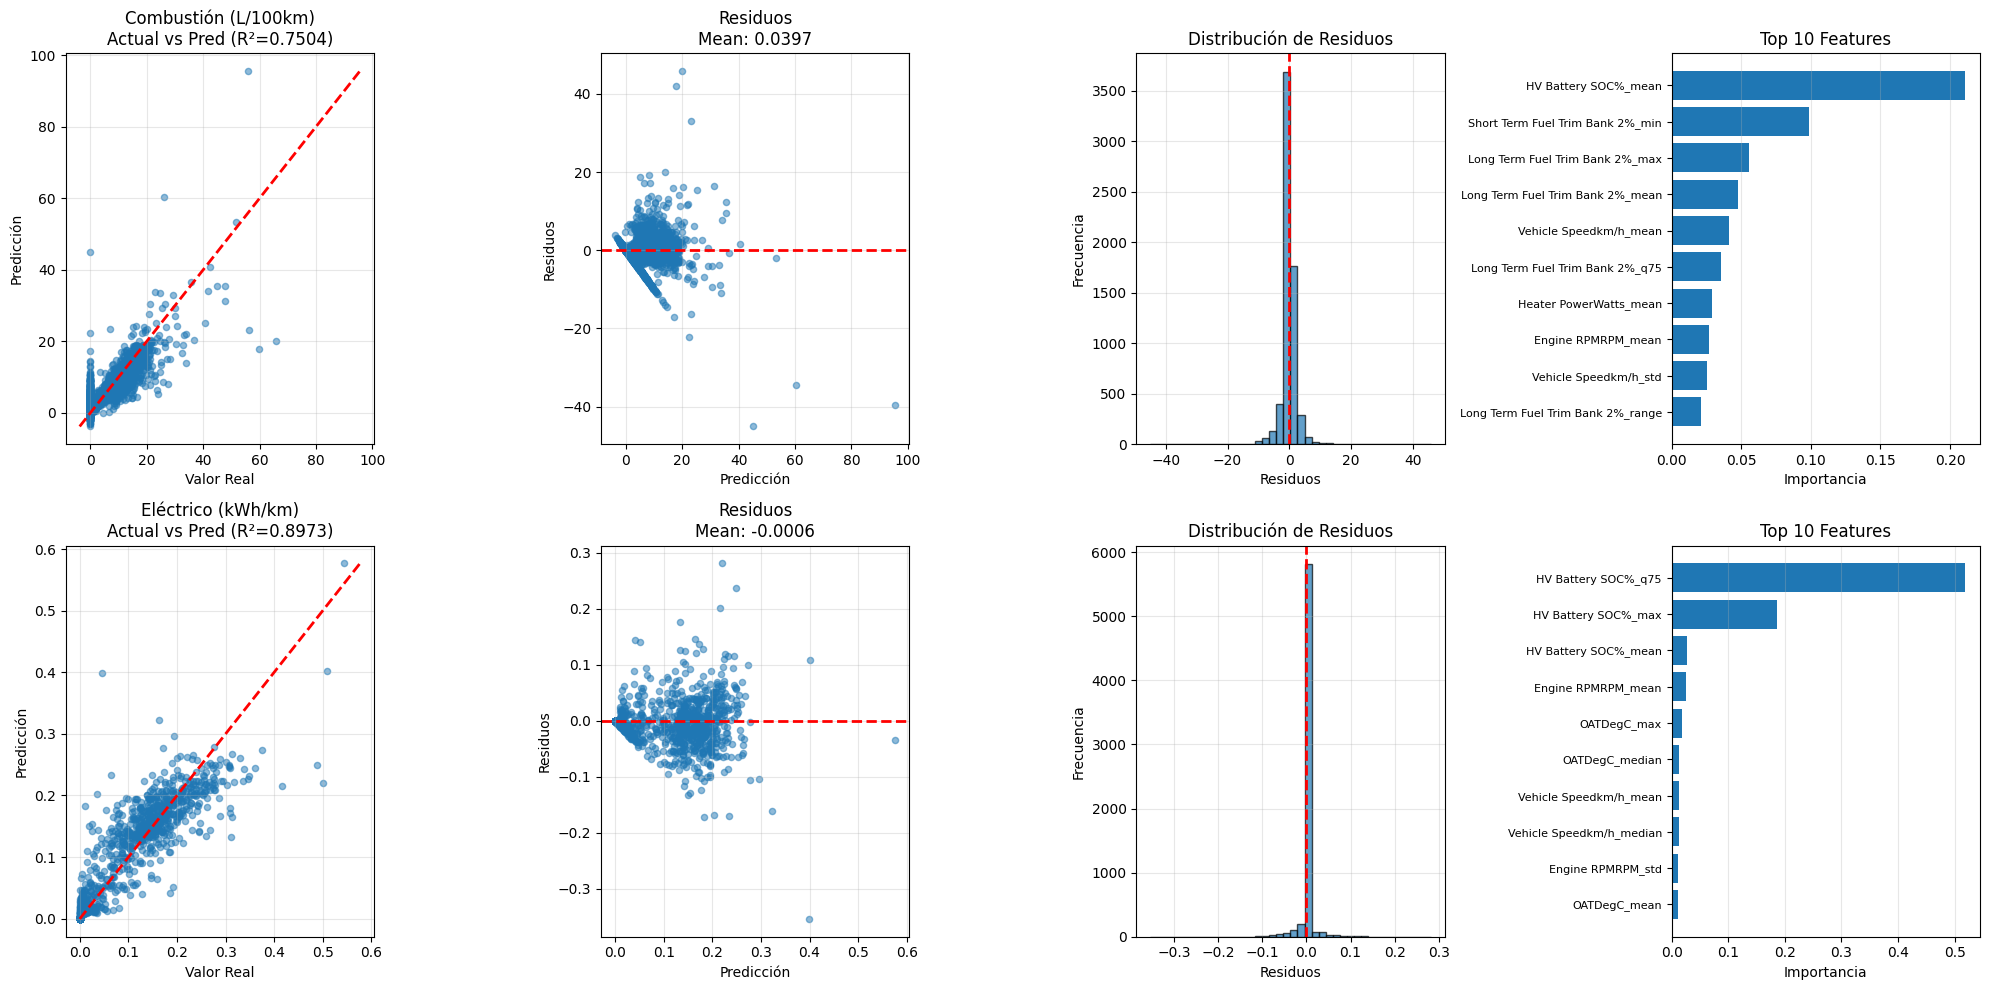


✓ Gráfico guardado en results\final_models_evaluation.png


In [65]:
# Visualización de resultados para ambos modelos
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row, (y_true, y_pred, model, name) in enumerate([
    (y_combustion_test, y_pred_combustion, model_combustion, 'Combustión (L/100km)'),
    (y_electric_test, y_pred_electric, model_electric, 'Eléctrico (kWh/km)')
]):
    r2 = r2_score(y_true, y_pred)
    residuals = y_true - y_pred
    
    # 1. Actual vs Predicted
    ax1 = axes[row, 0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax1.set_xlabel('Valor Real')
    ax1.set_ylabel('Predicción')
    ax1.set_title(f'{name}\nActual vs Pred (R²={r2:.4f})')
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuos
    ax2 = axes[row, 1]
    ax2.scatter(y_pred, residuals, alpha=0.5, s=20)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicción')
    ax2.set_ylabel('Residuos')
    ax2.set_title(f'Residuos\nMean: {residuals.mean():.4f}')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribución de residuos
    ax3 = axes[row, 2]
    ax3.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='r', linestyle='--', lw=2)
    ax3.set_xlabel('Residuos')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Residuos')
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature Importance
    ax4 = axes[row, 3]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    ax4.barh(range(10), importances[indices][::-1])
    ax4.set_yticks(range(10))
    ax4.set_yticklabels([sanitized_feature_cols[i] for i in indices][::-1], fontsize=8)
    ax4.set_xlabel('Importancia')
    ax4.set_title('Top 10 Features')
    ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'final_models_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en {RESULTS_DIR / 'final_models_evaluation.png'}")

In [66]:
# Comparación con baselines para ambos targets
print("="*70)
print("                COMPARACIÓN CON BASELINES")
print("="*70)

# Baselines para COMBUSTIÓN
mean_pred_comb = np.full(len(y_combustion_test), y_combustion_dev.mean())
median_pred_comb = np.full(len(y_combustion_test), np.median(y_combustion_dev))

baseline_comb = pd.DataFrame({
    'Model': ['XGBoost', 'Baseline (Mean)', 'Baseline (Median)'],
    'RMSE': [
        metrics_combustion['rmse'],
        np.sqrt(mean_squared_error(y_combustion_test, mean_pred_comb)),
        np.sqrt(mean_squared_error(y_combustion_test, median_pred_comb))
    ],
    'R2': [
        metrics_combustion['r2'],
        r2_score(y_combustion_test, mean_pred_comb),
        r2_score(y_combustion_test, median_pred_comb)
    ]
})

print("\nCOMBUSTIÓN (L/100km):")
display(baseline_comb)
rmse_improvement_comb = (baseline_comb.iloc[1]['RMSE'] - baseline_comb.iloc[0]['RMSE']) / baseline_comb.iloc[1]['RMSE'] * 100
print(f"  → Mejora sobre Mean Baseline: {rmse_improvement_comb:.1f}% en RMSE")

# Baselines para ELÉCTRICO
mean_pred_elec = np.full(len(y_electric_test), y_electric_dev.mean())
median_pred_elec = np.full(len(y_electric_test), np.median(y_electric_dev))

baseline_elec = pd.DataFrame({
    'Model': ['XGBoost', 'Baseline (Mean)', 'Baseline (Median)'],
    'RMSE': [
        metrics_electric['rmse'],
        np.sqrt(mean_squared_error(y_electric_test, mean_pred_elec)),
        np.sqrt(mean_squared_error(y_electric_test, median_pred_elec))
    ],
    'R2': [
        metrics_electric['r2'],
        r2_score(y_electric_test, mean_pred_elec),
        r2_score(y_electric_test, median_pred_elec)
    ]
})

print("\nELÉCTRICO (kWh/km):")
display(baseline_elec)
rmse_improvement_elec = (baseline_elec.iloc[1]['RMSE'] - baseline_elec.iloc[0]['RMSE']) / baseline_elec.iloc[1]['RMSE'] * 100
print(f"  → Mejora sobre Mean Baseline: {rmse_improvement_elec:.1f}% en RMSE")

                COMPARACIÓN CON BASELINES

COMBUSTIÓN (L/100km):


,Model,RMSE,R2
0,XGBoost,2.567425,0.750425
1,Baseline (Mean),5.139583,-0.000142
2,Baseline (Median),5.140082,-0.000336


  → Mejora sobre Mean Baseline: 50.0% en RMSE

ELÉCTRICO (kWh/km):


,Model,RMSE,R2
0,XGBoost,0.016704,0.897270
1,Baseline (Mean),0.052117,-0.000041
2,Baseline (Median),0.054497,-0.093428


  → Mejora sobre Mean Baseline: 67.9% en RMSE


## 6. Guardar Modelos Finales

In [67]:
# Guardar modelos finales y artefactos
final_model_dir = MODELS_DIR / 'final'
final_model_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelo de COMBUSTIÓN
joblib.dump(model_combustion, final_model_dir / 'xgboost_combustion.pkl')
joblib.dump(random_search_combustion.best_params_, final_model_dir / 'best_params_combustion.pkl')

# Guardar modelo de ELÉCTRICO
joblib.dump(model_electric, final_model_dir / 'xgboost_electric.pkl')
joblib.dump(random_search_electric.best_params_, final_model_dir / 'best_params_electric.pkl')

# Guardar scaler (compartido)
joblib.dump(scaler_dev, final_model_dir / 'scaler_final.pkl')

# Guardar nombres de features
joblib.dump(sanitized_feature_cols, final_model_dir / 'feature_names.pkl')

# Guardar métricas finales
final_metrics = {
    'combustion': {
        **metrics_combustion,
        'cv_rmse': cv_rmse_combustion,
        'best_iteration': model_combustion.best_iteration
    },
    'electric': {
        **metrics_electric,
        'cv_rmse': cv_rmse_electric,
        'best_iteration': model_electric.best_iteration
    },
    'n_features': len(sanitized_feature_cols),
    'n_train_samples': len(X_dev),
    'n_test_samples': len(X_test)
}
joblib.dump(final_metrics, final_model_dir / 'final_metrics.pkl')

print("✓ Artefactos guardados:")
print(f"  - Modelo Combustión: {final_model_dir / 'xgboost_combustion.pkl'}")
print(f"  - Modelo Eléctrico: {final_model_dir / 'xgboost_electric.pkl'}")
print(f"  - Scaler: {final_model_dir / 'scaler_final.pkl'}")
print(f"  - Features: {final_model_dir / 'feature_names.pkl'}")
print(f"  - Métricas: {final_model_dir / 'final_metrics.pkl'}")

✓ Artefactos guardados:
  - Modelo Combustión: models\saved_models\final\xgboost_combustion.pkl
  - Modelo Eléctrico: models\saved_models\final\xgboost_electric.pkl
  - Scaler: models\saved_models\final\scaler_final.pkl
  - Features: models\saved_models\final\feature_names.pkl
  - Métricas: models\saved_models\final\final_metrics.pkl


## 7. Resumen Final

In [68]:
print("="*70)
print("                    RESUMEN DEL PROYECTO")
print("="*70)
print()
print("MODELOS FINALES: XGBoost Regressor (x2)")
print()
print("DATOS:")
print(f"  - Dataset: Metrics (estadísticas agregadas por viaje)")
print(f"  - Features: {len(sanitized_feature_cols)}")
print(f"  - Samples totales: {len(X)}")
print(f"  - Dev set: {len(X_dev)} samples (80%)")
print(f"  - Test set: {len(X_test)} samples (20%)")
print()

print("="*70)
print("MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)")
print("="*70)
print("\nHiperparámetros óptimos:")
for param, value in random_search_combustion.best_params_.items():
    if isinstance(value, float):
        print(f"  - {param}: {value:.4f}")
    else:
        print(f"  - {param}: {value}")
print(f"\nMétricas (Test Set):")
print(f"  - RMSE: {metrics_combustion['rmse']:.4f}")
print(f"  - MAE:  {metrics_combustion['mae']:.4f}")
print(f"  - R²:   {metrics_combustion['r2']:.4f}")
print(f"\nVerosimilitud:")
print(f"  - CV RMSE: {cv_rmse_combustion:.4f}")
print(f"  - Test RMSE: {metrics_combustion['rmse']:.4f}")
diff_comb = abs(cv_rmse_combustion - metrics_combustion['rmse'])/cv_rmse_combustion
print(f"  - Diferencia: {diff_comb*100:.1f}%", end="")
print(" ✓" if diff_comb < 0.1 else " ⚠")

print()
print("="*70)
print("MODELO 2: CONSUMO ELÉCTRICO (kWh/km)")
print("="*70)
print("\nHiperparámetros óptimos:")
for param, value in random_search_electric.best_params_.items():
    if isinstance(value, float):
        print(f"  - {param}: {value:.4f}")
    else:
        print(f"  - {param}: {value}")
print(f"\nMétricas (Test Set):")
print(f"  - RMSE: {metrics_electric['rmse']:.4f}")
print(f"  - MAE:  {metrics_electric['mae']:.4f}")
print(f"  - R²:   {metrics_electric['r2']:.4f}")
print(f"\nVerosimilitud:")
print(f"  - CV RMSE: {cv_rmse_electric:.4f}")
print(f"  - Test RMSE: {metrics_electric['rmse']:.4f}")
diff_elec = abs(cv_rmse_electric - metrics_electric['rmse'])/cv_rmse_electric
print(f"  - Diferencia: {diff_elec*100:.1f}%", end="")
print(" ✓" if diff_elec < 0.1 else " ⚠")

print()
print("="*70)
print("                    FIN DEL PROYECTO")
print("="*70)

                    RESUMEN DEL PROYECTO

MODELOS FINALES: XGBoost Regressor (x2)

DATOS:
  - Dataset: Metrics (estadísticas agregadas por viaje)
  - Features: 98
  - Samples totales: 32512
  - Dev set: 26009 samples (80%)
  - Test set: 6503 samples (20%)

MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)

Hiperparámetros óptimos:
  - colsample_bytree: 0.7185
  - gamma: 0.4045
  - learning_rate: 0.1116
  - max_depth: 7
  - min_child_weight: 2
  - n_estimators: 378
  - reg_alpha: 0.1431
  - reg_lambda: 0.5626
  - subsample: 0.8657

Métricas (Test Set):
  - RMSE: 2.5674
  - MAE:  1.3265
  - R²:   0.7504

Verosimilitud:
  - CV RMSE: 3.3379
  - Test RMSE: 2.5674
  - Diferencia: 23.1% ⚠

MODELO 2: CONSUMO ELÉCTRICO (kWh/km)

Hiperparámetros óptimos:
  - colsample_bytree: 0.8866
  - gamma: 0.0037
  - learning_rate: 0.0796
  - max_depth: 6
  - min_child_weight: 6
  - n_estimators: 380
  - reg_alpha: 0.1345
  - reg_lambda: 1.7547
  - subsample: 0.9333

Métricas (Test Set):
  - RMSE: 0.0167
  - MAE:  0